In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import sqlite3 as sql
import re
import requests
from bs4 import BeautifulSoup
from functools import reduce

In [2]:
home_value_index = pd.read_csv('../data/zillow_home_value_index.csv')
home_value_index.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
0,102001,0,United States,Country,NaN,127202.0,127546.0,127908.0,128645.0,129389.0,...,271623.0,274979.0,278635.0,282495.0,287202.0,292730.0,298613.0,304008.0,308632.0,312728.0
1,394913,1,"New York, NY",Msa,NY,224341.0,225681.0,226887.0,229261.0,231472.0,...,516687.0,521426.0,525792.0,530533.0,536044.0,543211.0,551142.0,558738.0,564641.0,569191.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,231193.0,231998.0,233231.0,235576.0,238089.0,...,741209.0,748698.0,756569.0,767615.0,783282.0,803090.0,823992.0,837437.0,846549.0,851308.0
3,394463,3,"Chicago, IL",Msa,IL,170104.0,170505.0,171024.0,172064.0,173166.0,...,258211.0,260534.0,262648.0,265690.0,268442.0,272263.0,276430.0,280547.0,283620.0,286280.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,130035.0,130139.0,130225.0,130437.0,130658.0,...,276637.0,280005.0,284015.0,289524.0,295921.0,303225.0,311010.0,318887.0,326057.0,332118.0


In [3]:
home_value_index.shape

(908, 267)

In [4]:
home_value_index.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
903,394767,929,"Lamesa, TX",Msa,TX,NaN,NaN,NaN,NaN,NaN,...,81702.0,82847.0,84199.0,84499.0,84998.0,85445.0,86421.0,87549.0,88609.0,89544.0
904,753874,930,"Craig, CO",Msa,CO,94741.0,95085.0,95668.0,96360.0,97075.0,...,NaN,214132.0,219224.0,223021.0,226345.0,229787.0,232861.0,236543.0,239833.0,242809.0
905,394968,931,"Pecos, TX",Msa,TX,NaN,NaN,NaN,NaN,NaN,...,136993.0,139388.0,141606.0,143469.0,145612.0,147618.0,150033.0,155032.0,159714.0,164353.0
906,395188,932,"Vernon, TX",Msa,TX,NaN,NaN,NaN,NaN,NaN,...,NaN,70218.0,71261.0,71623.0,72008.0,72666.0,73363.0,73961.0,74432.0,74762.0
907,394743,933,"Ketchikan, AK",Msa,AK,NaN,NaN,NaN,NaN,NaN,...,321416.0,322965.0,325062.0,327187.0,329357.0,330905.0,332472.0,334200.0,336433.0,338383.0


looks like the HVI goes from 2000-2021 could use parts of it to show trajectory of home value in area. Will need to expand the region name info to better fit

### Start by separating RegionName

In [5]:
home_value_index

#df['Col'].str.split(pat, n=-1, expand=False)

home_value_index['RegionName'] = home_value_index['RegionName'].astype(str)
home_value_index['RegionName'] = home_value_index['RegionName'].str.split(',', n = -1, expand = True)

# row 0 looks to be overall data for the country, don't need this.

home_value_index = home_value_index.drop(0).reset_index(drop = True)

#RegionType is all the same without 0, drop it

home_value_index = home_value_index.drop(columns = 'RegionType')
home_value_index

,RegionID,SizeRank,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
0,394913,1,New York,NY,224341.0,225681.0,226887.0,229261.0,231472.0,233825.0,...,516687.0,521426.0,525792.0,530533.0,536044.0,543211.0,551142.0,558738.0,564641.0,569191.0
1,753899,2,Los Angeles-Long Beach-Anaheim,CA,231193.0,231998.0,233231.0,235576.0,238089.0,240463.0,...,741209.0,748698.0,756569.0,767615.0,783282.0,803090.0,823992.0,837437.0,846549.0,851308.0
2,394463,3,Chicago,IL,170104.0,170505.0,171024.0,172064.0,173166.0,174257.0,...,258211.0,260534.0,262648.0,265690.0,268442.0,272263.0,276430.0,280547.0,283620.0,286280.0
3,394514,4,Dallas-Fort Worth,TX,130035.0,130139.0,130225.0,130437.0,130658.0,130843.0,...,276637.0,280005.0,284015.0,289524.0,295921.0,303225.0,311010.0,318887.0,326057.0,332118.0
4,394974,5,Philadelphia,PA,129808.0,130243.0,130505.0,131154.0,131680.0,132274.0,...,277412.0,280529.0,283627.0,286951.0,291300.0,296131.0,300660.0,304281.0,307143.0,309597.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,394767,929,Lamesa,TX,NaN,NaN,NaN,NaN,NaN,NaN,...,81702.0,82847.0,84199.0,84499.0,84998.0,85445.0,86421.0,87549.0,88609.0,89544.0
903,753874,930,Craig,CO,94741.0,95085.0,95668.0,96360.0,97075.0,97615.0,...,NaN,214132.0,219224.0,223021.0,226345.0,229787.0,232861.0,236543.0,239833.0,242809.0
904,394968,931,Pecos,TX,NaN,NaN,NaN,NaN,NaN,NaN,...,136993.0,139388.0,141606.0,143469.0,145612.0,147618.0,150033.0,155032.0,159714.0,164353.0
905,395188,932,Vernon,TX,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,70218.0,71261.0,71623.0,72008.0,72666.0,73363.0,73961.0,74432.0,74762.0


In [6]:
home_value_index = home_value_index.drop(columns = ['RegionID', 'SizeRank'])

hvi_melt = pd.melt(home_value_index, id_vars = ['RegionName', 'StateName'])

hvi_melt = hvi_melt.rename(columns = {'variable' : 'SalesMonth', 'value' : 'AveragePrice'})

#remove non-number rows in SalesMonth
#df.drop(index=df[df['road'] == '(R)'].index, inplace=True)
hvi_melt.drop(index = hvi_melt[hvi_melt['SalesMonth'] == 'RegionType'].index, inplace = True)

#df = df[df['EPS'].notna()]
hvi_melt = hvi_melt[hvi_melt['StateName'].notna()]
hvi_melt = hvi_melt[hvi_melt['SalesMonth'].notna()]
hvi_melt = hvi_melt[hvi_melt['AveragePrice'].notna()].reset_index(drop = True)
hvi_melt

,RegionName,StateName,SalesMonth,AveragePrice
0,New York,NY,2000-01-31,224341.0
1,Los Angeles-Long Beach-Anaheim,CA,2000-01-31,231193.0
2,Chicago,IL,2000-01-31,170104.0
3,Dallas-Fort Worth,TX,2000-01-31,130035.0
4,Philadelphia,PA,2000-01-31,129808.0
...,...,...,...,...
188902,Lamesa,TX,2021-10-31,89544.0
188903,Craig,CO,2021-10-31,242809.0
188904,Pecos,TX,2021-10-31,164353.0
188905,Vernon,TX,2021-10-31,74762.0


# need to add a range based on AveragePrice

In [7]:
hvi_melt['AveragePrice'].max()

1493020.0

In [8]:
#create function to create ranges and use .apply()

#alternatively se cut and qcut functions
def price_range(value):
    if value < 50000:
        price_range = 'Under $50,000'
    elif value < 100000:
        price_range = '$50,000 - $100,000'
    elif value < 150000:
        price_range = '$100,000 - $150,000'
    elif value < 200000:
        price_range = '$150,000 - $200,000'
    elif value < 250000:
        price_range = '$200,000 - $250,000'
    elif value < 300000:
        price_range = '$250,000 - $300,000'
    elif value < 350000:
        price_range = '$300,000 - $350,000'
    elif value < 400000:
        price_range = '$350,000 - $400,000'
    elif value < 450000:
        price_range = '$400,000 - $450,000'
    elif value < 500000:
        price_range = '$450,000 - $500,000'
    elif value < 550000:
        price_range = '$500,000 - $550,000'
    elif value < 600000:
        price_range = '$550,000 - $600,000'
    elif value < 650000:
        price_range = '$600,000 - $650,000'
    elif value < 700000:
        price_range = '$650,000 - $700,000'
    elif value < 750000:
        price_range = '$700,000 - $750,000'
    elif value < 800000:
        price_range = '$750,000 - $800,000'
    elif value < 850000:
        price_range = '$800,000 - $850,000'
    elif value < 900000:
        price_range = '$850,000 - $900,000'
    elif value < 950000:
        price_range = '$900,000 - $950,000'
    elif value < 1000000:
        price_range = '$950,000 - $1,000,000'
    elif value < 1050000:
        price_range = '$1,000,000 - $1,050,000'
    elif value < 1100000:
        price_range = '$1,050,000 - $1,100,000'
    elif value < 1150000:
        price_range = '$1,100,000 - $1,150,000'
    elif value < 1200000:
        price_range = '$1,150,000 - $1,200,000'
    elif value < 1250000:
        price_range = '$1,200,000 - $1,250,000'
    elif value < 1300000:
        price_range = '$1,250,000 - $1,300,000'
    elif value < 1350000:
        price_range = '$1,300,000 - $1,350,000'
    elif value < 1400000:
        price_range = '$1,350,000 - $1,400,000'
    elif value < 1450000:
        price_range = '$1,400,000 - $1,450,000'
    else:
        price_range = '$1,450,000 - $1,500,000'
        
    return price_range

In [9]:
hvi_melt['PriceRange'] = hvi_melt['AveragePrice'].apply(price_range)
hvi_melt

,RegionName,StateName,SalesMonth,AveragePrice,PriceRange
0,New York,NY,2000-01-31,224341.0,"$200,000 - $250,000"
1,Los Angeles-Long Beach-Anaheim,CA,2000-01-31,231193.0,"$200,000 - $250,000"
2,Chicago,IL,2000-01-31,170104.0,"$150,000 - $200,000"
3,Dallas-Fort Worth,TX,2000-01-31,130035.0,"$100,000 - $150,000"
4,Philadelphia,PA,2000-01-31,129808.0,"$100,000 - $150,000"
...,...,...,...,...,...
188902,Lamesa,TX,2021-10-31,89544.0,"$50,000 - $100,000"
188903,Craig,CO,2021-10-31,242809.0,"$200,000 - $250,000"
188904,Pecos,TX,2021-10-31,164353.0,"$150,000 - $200,000"
188905,Vernon,TX,2021-10-31,74762.0,"$50,000 - $100,000"


In [10]:
list_sale_prices = pd.read_csv('../data/zillow_list_sale_prices.csv')
list_sale_prices.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
0,102001,0,United States,Country,NaN,271600.0,272967.0,279333.0,288667.0,295633.0,...,333533.0,333850.0,340362.0,353728.0,367045.0,378267.0,381567.0,379933.0,376633.0,375000.0
1,394913,1,"New York, NY",Msa,NY,517967.0,523000.0,534333.0,544667.0,554666.0,...,661666.0,668000.0,673000.0,675000.0,675000.0,666667.0,658000.0,643200.0,636533.0,631867.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,798333.0,802667.0,818000.0,835000.0,848300.0,...,996997.0,998698.0,1005698.0,1006364.0,1006666.0,999666.0,991333.0,971333.0,946667.0,931633.0
3,394463,3,"Chicago, IL",Msa,IL,301000.0,305967.0,319300.0,335967.0,345967.0,...,331333.0,331667.0,338300.0,346633.0,352967.0,354667.0,354633.0,348267.0,339933.0,332967.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,341996.0,345330.0,351663.0,359830.0,366163.0,...,350726.0,352141.0,357025.0,365358.0,374884.0,383333.0,390167.0,393500.0,396500.0,397667.0


In [11]:
list_sale_prices.shape

(95, 51)

In [12]:
list_sale_prices.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
90,394528,90,"Daytona Beach, FL",Msa,FL,269600.0,270300.0,271833.0,274833.0,279667.0,...,293410.0,297110.0,303500.0,314467.0,324467.0,336078.0,341612.0,346278.0,348000.0,352967.0
91,394531,91,"Des Moines, IA",Msa,IA,281600.0,285967.0,292293.0,297293.0,299593.0,...,273633.0,277767.0,283300.0,291378.0,301725.0,311707.0,319628.0,320032.0,317550.0,314217.0
92,395006,100,"Provo, UT",Msa,UT,389707.0,397680.0,408503.0,413706.0,409865.0,...,511346.0,515076.0,510630.0,512444.0,520778.0,537478.0,546633.0,549967.0,548467.0,545533.0
93,394549,104,"Durham, NC",Msa,NC,362699.0,367241.0,375112.0,382984.0,386785.0,...,427593.0,431818.0,442273.0,466005.0,485372.0,495967.0,487633.0,480160.0,476526.0,478160.0
94,394602,159,"Fort Collins, CO",Msa,CO,442736.0,445785.0,448272.0,450000.0,454094.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


doesn't have as much region data, may not be able to use this information.

Having trouble using the dates to create visualization wanted. Let's try melting this into a new shape

In [13]:
# actually, I don't even need RegionID or SizeRank, let's get rid of them first

list_sale_prices = list_sale_prices.drop(columns = ['RegionID', 'SizeRank'])

lsp_melt = pd.melt(list_sale_prices, id_vars = ['RegionName', 'StateName'])

lsp_melt = lsp_melt.rename(columns = {'variable' : 'SalesMonth', 'value' : 'AveragePrice'})

#remove non-number rows in SalesMonth
#df.drop(index=df[df['road'] == '(R)'].index, inplace=True)
lsp_melt.drop(index = lsp_melt[lsp_melt['SalesMonth'] == 'RegionType'].index, inplace = True)

#df.dropna(subset = ['column1_name', 'column2_name', 'column3_name'])
#lsp_melt.dropna(subset = ['StateName', 'SalesMonth', 'AveragePrice'])
#not working, try another tactic
#df = df[df['EPS'].notna()]
lsp_melt = lsp_melt[lsp_melt['StateName'].notna()]
lsp_melt = lsp_melt[lsp_melt['SalesMonth'].notna()]
lsp_melt = lsp_melt[lsp_melt['AveragePrice'].notna()].reset_index(drop = True)
lsp_melt


,RegionName,StateName,SalesMonth,AveragePrice
0,"New York, NY",NY,2018-01-31,517967.0
1,"Los Angeles-Long Beach-Anaheim, CA",CA,2018-01-31,798333.0
2,"Chicago, IL",IL,2018-01-31,301000.0
3,"Dallas-Fort Worth, TX",TX,2018-01-31,341996.0
4,"Philadelphia, PA",PA,2018-01-31,252633.0
...,...,...,...,...
4202,"Lakeland, FL",FL,2021-10-31,318065.0
4203,"Daytona Beach, FL",FL,2021-10-31,352967.0
4204,"Des Moines, IA",IA,2021-10-31,314217.0
4205,"Provo, UT",UT,2021-10-31,545533.0


# need to add a range based on AveragePrice

In [14]:
lsp_melt['PriceRange'] = lsp_melt['AveragePrice'].apply(price_range)
lsp_melt

,RegionName,StateName,SalesMonth,AveragePrice,PriceRange
0,"New York, NY",NY,2018-01-31,517967.0,"$500,000 - $550,000"
1,"Los Angeles-Long Beach-Anaheim, CA",CA,2018-01-31,798333.0,"$750,000 - $800,000"
2,"Chicago, IL",IL,2018-01-31,301000.0,"$300,000 - $350,000"
3,"Dallas-Fort Worth, TX",TX,2018-01-31,341996.0,"$300,000 - $350,000"
4,"Philadelphia, PA",PA,2018-01-31,252633.0,"$250,000 - $300,000"
...,...,...,...,...,...
4202,"Lakeland, FL",FL,2021-10-31,318065.0,"$300,000 - $350,000"
4203,"Daytona Beach, FL",FL,2021-10-31,352967.0,"$350,000 - $400,000"
4204,"Des Moines, IA",IA,2021-10-31,314217.0,"$300,000 - $350,000"
4205,"Provo, UT",UT,2021-10-31,545533.0,"$500,000 - $550,000"


In [15]:
# need to split city/region data to remove state abbreviation
lsp_melt['RegionName'] = lsp_melt['RegionName'].astype(str)

#split RegionName to get RN and State
lsp_melt['RegionName'] = lsp_melt['RegionName'].str.extract('(.+),')
lsp_melt

,RegionName,StateName,SalesMonth,AveragePrice,PriceRange
0,New York,NY,2018-01-31,517967.0,"$500,000 - $550,000"
1,Los Angeles-Long Beach-Anaheim,CA,2018-01-31,798333.0,"$750,000 - $800,000"
2,Chicago,IL,2018-01-31,301000.0,"$300,000 - $350,000"
3,Dallas-Fort Worth,TX,2018-01-31,341996.0,"$300,000 - $350,000"
4,Philadelphia,PA,2018-01-31,252633.0,"$250,000 - $300,000"
...,...,...,...,...,...
4202,Lakeland,FL,2021-10-31,318065.0,"$300,000 - $350,000"
4203,Daytona Beach,FL,2021-10-31,352967.0,"$350,000 - $400,000"
4204,Des Moines,IA,2021-10-31,314217.0,"$300,000 - $350,000"
4205,Provo,UT,2021-10-31,545533.0,"$500,000 - $550,000"


In [16]:
rentals = pd.read_csv('../data/zillow_rentals.csv')
rentals.head()

,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
0,102001,United States,0,1347.0,1352,1358.0,1364,1369,1375,1380,...,1727,1744,1761,1777,1795.0,1813,1830,1849,1867.0,1886.0
1,394913,"New York, NY",1,2356.0,2366,2376.0,2387,2397,2408,2418,...,2592,2608,2624,2640,2658.0,2676,2694,2715,2736.0,2757.0
2,753899,"Los Angeles-Long Beach-Anaheim, CA",2,1719.0,1730,1740.0,1750,1761,1771,1782,...,2347,2366,2384,2402,2421.0,2440,2459,2480,2500.0,2521.0
3,394463,"Chicago, IL",3,1374.0,1378,1381.0,1385,1388,1392,1395,...,1583,1591,1599,1607,1615.0,1624,1633,1642,1652.0,1661.0
4,394514,"Dallas-Fort Worth, TX",4,1125.0,1129,1132.0,1136,1139,1143,1147,...,1480,1498,1516,1534,1552.0,1571,1589,1608,1628.0,1647.0


In [17]:
rentals.tail()

,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
100,394549,"Durham, NC",104,1102.0,1105,1109.0,1112,1116,1119,1123,...,1393,1407,1420,1434,1448.0,1462,1476,1491,1506.0,1520.0
101,394995,"Port St. Lucie, FL",119,1057.0,1065,1073.0,1081,1089,1097,1104,...,1703,1732,1760,1789,1818.0,1848,1877,1907,1938.0,1968.0
102,394602,"Fort Collins, CO",159,1213.0,1219,1226.0,1233,1239,1246,1253,...,1581,1594,1608,1621,1634.0,1648,1662,1676,1690.0,1704.0
103,394405,"Boulder, CO",162,1502.0,1509,1517.0,1524,1532,1540,1548,...,2006,2022,2038,2054,2070.0,2087,2103,2119,2136.0,2152.0
104,394623,"Gainesville, GA",229,940.0,943,945.0,947,950,953,956,...,1392,1416,1439,1463,NaN,1511,1535,1560,1585.0,1610.0


In [18]:
rentals.shape

(105, 97)

need to investigate infomation on how the numbers are figured.

is this an average of all rentals? 

In [19]:
#drop row 0 to start

rentals = rentals.drop(0).reset_index(drop = True)

#change RegionName to string

rentals['RegionName'] = rentals['RegionName'].astype(str)

#split RegionName to get RN and State
rentals[['RegionName', 'State']] = rentals['RegionName'].str.split(',', n=1, expand=True)

#rearrange the columns
# cols = list(df.columns)
# cols = [cols[-1]] + cols[:-1]
# df = df[cols]

cols = list(rentals.columns)
cols = [cols[-1]] + cols[:-3]
rentals = rentals[cols]

rentals

,State,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
0,NY,394913,New York,1,2356.0,2366,2376.0,2387,2397,2408,...,2595,2594,2592,2608,2624,2640,2658.0,2676,2694,2715
1,CA,753899,Los Angeles-Long Beach-Anaheim,2,1719.0,1730,1740.0,1750,1761,1771,...,2328,2338,2347,2366,2384,2402,2421.0,2440,2459,2480
2,IL,394463,Chicago,3,1374.0,1378,1381.0,1385,1388,1392,...,1577,1580,1583,1591,1599,1607,1615.0,1624,1633,1642
3,TX,394514,Dallas-Fort Worth,4,1125.0,1129,1132.0,1136,1139,1143,...,1457,1468,1480,1498,1516,1534,1552.0,1571,1589,1608
4,PA,394974,Philadelphia,5,1335.0,1338,1341.0,1343,1346,1349,...,1598,1605,1612,1623,1634,1645,1656.0,1667,1678,1690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,NC,394549,Durham,104,1102.0,1105,1109.0,1112,1116,1119,...,1376,1385,1393,1407,1420,1434,1448.0,1462,1476,1491
100,FL,394995,Port St. Lucie,119,1057.0,1065,1073.0,1081,1089,1097,...,1658,1680,1703,1732,1760,1789,1818.0,1848,1877,1907
101,CO,394602,Fort Collins,159,1213.0,1219,1226.0,1233,1239,1246,...,1563,1572,1581,1594,1608,1621,1634.0,1648,1662,1676
102,CO,394405,Boulder,162,1502.0,1509,1517.0,1524,1532,1540,...,1981,1994,2006,2022,2038,2054,2070.0,2087,2103,2119


In [20]:
rentals = rentals.drop(columns = ['RegionID', 'SizeRank'])

r_melt = pd.melt(rentals, id_vars = ['RegionName', 'State'])

r_melt = r_melt.rename(columns = {'variable' : 'Month', 'value' : 'AveragePrice'})

#remove non-number rows in SalesMonth
#df.drop(index=df[df['road'] == '(R)'].index, inplace=True)
r_melt.drop(index = r_melt[r_melt['Month'] == 'RegionType'].index, inplace = True)

#df = df[df['EPS'].notna()]
r_melt = r_melt[r_melt['State'].notna()]
r_melt = r_melt[r_melt['Month'].notna()]
r_melt = r_melt[r_melt['AveragePrice'].notna()].reset_index(drop = True)
r_melt

,RegionName,State,Month,AveragePrice
0,New York,NY,2014-01,2356.0
1,Los Angeles-Long Beach-Anaheim,CA,2014-01,1719.0
2,Chicago,IL,2014-01,1374.0
3,Dallas-Fort Worth,TX,2014-01,1125.0
4,Philadelphia,PA,2014-01,1335.0
...,...,...,...,...
9556,Durham,NC,2021-08,1491.0
9557,Port St. Lucie,FL,2021-08,1907.0
9558,Fort Collins,CO,2021-08,1676.0
9559,Boulder,CO,2021-08,2119.0


# need to add a range based on AveragePrice

In [21]:
# recreate price_range as rent_range

#r_melt['AveragePrice'].max() #3111
#r_melt['AveragePrice'].min() #615

def rent_range(value):
    if value < 700:
        rent_range = 'Under $700'
    elif value < 800:
        rent_range = '$700 - $800'
    elif value < 900:
        rent_range = '$800 - $900'
    elif value < 1000:
        rent_range = '$900 - $1,000'
    elif value < 1100:
        rent_range = '$1,000 - $1,100'
    elif value < 1200:
        rent_range = '$1,100 - $1,200'
    elif value < 1300:
        rent_range = '$1,200 - $1,300'
    elif value < 1400:
        rent_range = '$1,300 - $1,400'
    elif value < 1500:
        rent_range = '$1,400 - $1,500'
    elif value < 1600:
        rent_range = '$1,500 - $1,600'
    elif value < 1700:
        rent_range = '$1,600 - $1,700'
    elif value < 1800:
        rent_range = '$1,700 - $1,800'
    elif value < 1900:
        rent_range = '$1,800 - $1,900'
    elif value < 2000:
        rent_range = '$1,900 - $2,000'
    elif value < 2100:
        rent_range = '$2,000 - $2,100'
    elif value < 2200:
        rent_range = '$2,100 - $2,200'
    elif value < 2300:
        rent_range = '$2,200 - $2,300'
    elif value < 2400:
        rent_range = '$2,300 - $2,400'
    elif value < 2500:
        rent_range = '$2,400 - $2,500'
    elif value < 2600:
        rent_range = '$2,500 - $2,600'
    elif value < 2700:
        rent_range = '$2,600 - $2,700'
    elif value < 2800:
        rent_range = '$2,700 - $2,800'
    elif value < 2900:
        rent_range = '$2,800 - $2,900'
    elif value < 3000:
        rent_range = '$2,900 - $3,000'
    elif value < 3100:
        rent_range = '$3,000 - $3,100'
    else:
        rent_range = '$3,100 - $3,200'
        
    return rent_range

In [22]:
r_melt['RentRange'] = r_melt['AveragePrice'].apply(rent_range)
r_melt

,RegionName,State,Month,AveragePrice,RentRange
0,New York,NY,2014-01,2356.0,"$2,300 - $2,400"
1,Los Angeles-Long Beach-Anaheim,CA,2014-01,1719.0,"$1,700 - $1,800"
2,Chicago,IL,2014-01,1374.0,"$1,300 - $1,400"
3,Dallas-Fort Worth,TX,2014-01,1125.0,"$1,100 - $1,200"
4,Philadelphia,PA,2014-01,1335.0,"$1,300 - $1,400"
...,...,...,...,...,...
9556,Durham,NC,2021-08,1491.0,"$1,400 - $1,500"
9557,Port St. Lucie,FL,2021-08,1907.0,"$1,900 - $2,000"
9558,Fort Collins,CO,2021-08,1676.0,"$1,600 - $1,700"
9559,Boulder,CO,2021-08,2119.0,"$2,100 - $2,200"


In [23]:
hate_crimes = pd.read_csv('../data/hate_crime.csv')
hate_crimes.head()

C:\Users\andid\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


In [24]:
hate_crimes.tail()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
219572,1318026,2020,WY0170100,Sheridan,NaN,City,WY,Wyoming,Mountain,West,...,White,Not Hispanic or Latino,2,Intimidation,2.0,Park/Playground,"Anti-Lesbian, Gay, Bisexual, or Transgender (M...",Individual,S,S
219573,1142103,2020,WY0210100,Evanston,NaN,City,WY,Wyoming,Mountain,West,...,Unknown,Unknown,1,Destruction/Damage/Vandalism of Property,0.0,Park/Playground,Anti-White,Government,S,S
219574,1318018,2020,WY0210100,Evanston,NaN,City,WY,Wyoming,Mountain,West,...,Black or African American,Not Hispanic or Latino,1,Aggravated Assault,1.0,Residence/Home,Anti-White,Individual,S,S
219575,1318022,2020,WY0210100,Evanston,NaN,City,WY,Wyoming,Mountain,West,...,White,Not Hispanic or Latino,1,Simple Assault,1.0,Residence/Home,Anti-Female,Individual,S,S
219576,1318023,2020,WY0210100,Evanston,NaN,City,WY,Wyoming,Mountain,West,...,White,Not Hispanic or Latino,1,Theft From Building,1.0,Residence/Home,Anti-Gender Non-Conforming,Individual,S,S


In [25]:
hate_crimes.shape

(219577, 28)

In [26]:
hate_crimes.columns.to_list()

['INCIDENT_ID',
 'DATA_YEAR',
 'ORI',
 'PUB_AGENCY_NAME',
 'PUB_AGENCY_UNIT',
 'AGENCY_TYPE_NAME',
 'STATE_ABBR',
 'STATE_NAME',
 'DIVISION_NAME',
 'REGION_NAME',
 'POPULATION_GROUP_CODE',
 'POPULATION_GROUP_DESC',
 'INCIDENT_DATE',
 'ADULT_VICTIM_COUNT',
 'JUVENILE_VICTIM_COUNT',
 'TOTAL_OFFENDER_COUNT',
 'ADULT_OFFENDER_COUNT',
 'JUVENILE_OFFENDER_COUNT',
 'OFFENDER_RACE',
 'OFFENDER_ETHNICITY',
 'VICTIM_COUNT',
 'OFFENSE_NAME',
 'TOTAL_INDIVIDUAL_VICTIMS',
 'LOCATION_NAME',
 'BIAS_DESC',
 'VICTIM_TYPES',
 'MULTIPLE_OFFENSE',
 'MULTIPLE_BIAS']

In [27]:
demo_top = pd.DataFrame(hate_crimes['BIAS_DESC'].value_counts())
demo_25 = demo_top.head(25).reset_index()
demo_25 = demo_25.rename(columns = {'index' : 'BIAS_DESC', 'BIAS_DESC' : 'DEMO_COUNT'})
demo_list = demo_25['BIAS_DESC'].tolist()
demo_list

['Anti-Black or African American',
 'Anti-Jewish',
 'Anti-White',
 'Anti-Gay (Male)',
 'Anti-Hispanic or Latino',
 'Anti-Other Race/Ethnicity/Ancestry',
 'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)',
 'Anti-Asian',
 'Anti-Multiple Races, Group',
 'Anti-Lesbian (Female)',
 'Anti-Islamic (Muslim)',
 'Anti-Other Religion',
 'Anti-American Indian or Alaska Native',
 'Anti-Catholic',
 'Anti-Arab',
 'Anti-Protestant',
 'Anti-Multiple Religions, Group',
 'Anti-Mental Disability',
 'Anti-Transgender',
 'Anti-Physical Disability',
 'Anti-Heterosexual',
 'Anti-Bisexual',
 'Anti-Sikh',
 'Anti-Female',
 'Anti-Gender Non-Conforming']

In [28]:
hate_crimes['MULTIPLE_BIAS'].value_counts()

S    218558
M      1019
Name: MULTIPLE_BIAS, dtype: int64

In [29]:
demo_data = hate_crimes.groupby(['DATA_YEAR', 'STATE_ABBR'])['BIAS_DESC'].value_counts()
demo_data

DATA_YEAR  STATE_ABBR  BIAS_DESC                                     
1991       AR          Anti-White                                         9
                       Anti-Black or African American                     3
           AZ          Anti-Black or African American                    23
                       Anti-Jewish                                        8
                       Anti-Protestant                                    5
                                                                         ..
2020       WY          Anti-White                                         2
                       Anti-Gender Non-Conforming                         1
                       Anti-Mormon                                        1
                       Anti-Native Hawaiian or Other Pacific Islander     1
                       Anti-Other Religion                                1
Name: BIAS_DESC, Length: 17963, dtype: int64

In [30]:
hc_grouped = hate_crimes.groupby(['DATA_YEAR', 'STATE_ABBR'])['OFFENSE_NAME'].value_counts()
hc_grouped

DATA_YEAR  STATE_ABBR  OFFENSE_NAME                                               
1991       AR          Intimidation                                                   4
                       Aggravated Assault                                             3
                       Robbery                                                        2
                       Aggravated Assault;Destruction/Damage/Vandalism of Property    1
                       Aggravated Assault;Murder and Nonnegligent Manslaughter        1
                                                                                     ..
2020       WY          Simple Assault                                                 8
                       Intimidation                                                   4
                       Destruction/Damage/Vandalism of Property                       3
                       Aggravated Assault                                             2
                       Theft From Bui

### Agency names don't always appear to sync to city names. Let's investigate the viability of creating a column of cities

In [31]:
agency_names = hate_crimes['PUB_AGENCY_NAME'].unique()
agency_list = pd.DataFrame(agency_names, columns = ['agency_name'])
agency_list

,agency_name
0,Rogers
1,Hope
2,Pine Bluff
3,Little Rock
4,North Little Rock
...,...
6533,Elkhart Lake
6534,Kohler
6535,Galesville
6536,Fox Crossing


### After looking at the list above and researching a location to find correlating city names it doesn't appear to be a viable option without a much larger lift. I'm deciding to adjust earlier code an will only use state info for hate crames. Additionally, let's only visualize the last decade of HC data for final dashboard and filter accordingly.

In [32]:
hc_ready = pd.DataFrame(data = hc_grouped)
hc_ready

OFFENSE_NAME
DATA_YEAR STATE_ABBR OFFENSE_NAME                                                    
1991      AR         Intimidation                                                   4
                     Aggravated Assault                                             3
                     Robbery                                                        2
                     Aggravated Assault;Destruction/Damage/Vandalism...             1
                     Aggravated Assault;Murder and Nonnegligent Mans...             1
...                                                                               ...
2020      WY         Simple Assault                                                 8
                     Intimidation                                                   4
                     Destruction/Damage/Vandalism of Property                       3
                     Aggravated Assault                                             2
                     Theft From Building                                            1

[15311 rows x 1 columns]

In [33]:
hc_ready = hc_ready.rename(columns = {'OFFENSE_NAME' : 'OFFENSE_COUNT'})
hc_ready = hc_ready.reset_index()

In [34]:
hc_ready

,DATA_YEAR,STATE_ABBR,OFFENSE_NAME,OFFENSE_COUNT
0,1991,AR,Intimidation,4
1,1991,AR,Aggravated Assault,3
2,1991,AR,Robbery,2
3,1991,AR,Aggravated Assault;Destruction/Damage/Vandalis...,1
4,1991,AR,Aggravated Assault;Murder and Nonnegligent Man...,1
...,...,...,...,...
15306,2020,WY,Simple Assault,8
15307,2020,WY,Intimidation,4
15308,2020,WY,Destruction/Damage/Vandalism of Property,3
15309,2020,WY,Aggravated Assault,2


In [35]:
hc_demo = pd.DataFrame(data = demo_data)

In [36]:
hc_demo = hc_demo.rename(columns = {'BIAS_DESC' : 'DEMO_COUNT'})
hc_demo = hc_demo.reset_index()

In [37]:
hc_demo

,DATA_YEAR,STATE_ABBR,BIAS_DESC,DEMO_COUNT
0,1991,AR,Anti-White,9
1,1991,AR,Anti-Black or African American,3
2,1991,AZ,Anti-Black or African American,23
3,1991,AZ,Anti-Jewish,8
4,1991,AZ,Anti-Protestant,5
...,...,...,...,...
17958,2020,WY,Anti-White,2
17959,2020,WY,Anti-Gender Non-Conforming,1
17960,2020,WY,Anti-Mormon,1
17961,2020,WY,Anti-Native Hawaiian or Other Pacific Islander,1


In [38]:
hc_demo = hc_demo[hc_demo['DATA_YEAR'] >= 2010]

## use demo_list to pull counts of only those groups returning the rest as other. Further we're going to work to combine the various LGB counts and the GNC/NB and Trans counts.

In [39]:
demo_main = hc_demo[hc_demo['BIAS_DESC'].isin(demo_list)]
demo_other = hc_demo[~hc_demo['BIAS_DESC'].isin(demo_list)]

In [40]:
# demo_data = hate_crimes.groupby(['DATA_YEAR', 'STATE_ABBR'])['BIAS_DESC'].value_counts()
demo_other = demo_other.groupby(['DATA_YEAR', 'STATE_ABBR'])['DEMO_COUNT'].sum()
demo_other = pd.DataFrame(data = demo_other).reset_index()
demo_other['BIAS_DESC'] = 'Other'
#rearrange columns to match demo_main ready to merge
#df = df[['a', 'y', 'b', 'x']]
demo_other = demo_other[['DATA_YEAR', 'STATE_ABBR', 'BIAS_DESC', 'DEMO_COUNT']]

demo_trim = pd.concat([demo_main, demo_other], axis = 0).reset_index(drop = True)
demo_trim

,DATA_YEAR,STATE_ABBR,BIAS_DESC,DEMO_COUNT
0,2010,AK,Anti-White,2
1,2010,AK,Anti-Black or African American,1
2,2010,AK,Anti-Gay (Male),1
3,2010,AK,Anti-Islamic (Muslim),1
4,2010,AK,Anti-Mental Disability,1
...,...,...,...,...
7337,2020,VT,Other,1
7338,2020,WA,Other,26
7339,2020,WI,Other,10
7340,2020,WV,Other,12


In [41]:
demo_trim['BIAS_DESC'].value_counts()

Anti-Black or African American                               539
Anti-White                                                   500
Anti-Gay (Male)                                              485
Anti-Hispanic or Latino                                      440
Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)    438
Anti-Jewish                                                  426
Anti-Other Race/Ethnicity/Ancestry                           393
Anti-Islamic (Muslim)                                        380
Anti-Multiple Races, Group                                   354
Anti-Lesbian (Female)                                        343
Anti-Asian                                                   343
Anti-Other Religion                                          311
Anti-American Indian or Alaska Native                        261
Other                                                        254
Anti-Catholic                                                246
Anti-Mental Disability   

In [42]:
# let's transform the data to clean it a little more by grouping all the LGB entries together with the grander anti-LGBT entry, GNC and Trans together and change anti-white to other as this is largely tageting minority groups
# df.loc[df['First Season'] > 1990, 'First Season'] = 1
demo_trim.loc[demo_trim['BIAS_DESC'].isin({'Anti-White', 'Anti-Heterosexual'}), 'BIAS_DESC'] = 'Other'
demo_trim.loc[demo_trim['BIAS_DESC'].isin({'Anti-Gay (Male)', 'Anti-Lesbian (Female)', 'Anti-Bisexual'}), 'BIAS_DESC'] = 'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)'
demo_trim.loc[demo_trim['BIAS_DESC'].isin({'Anti-Transgender', 'Anti-Gender Non-Conforming'}), 'BIAS_DESC'] = 'Anti-Transgender/Gender Non-Conforming'
demo_trim['BIAS_DESC'].value_counts()

Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)    1418
Other                                                         878
Anti-Black or African American                                539
Anti-Hispanic or Latino                                       440
Anti-Jewish                                                   426
Anti-Other Race/Ethnicity/Ancestry                            393
Anti-Islamic (Muslim)                                         380
Anti-Multiple Races, Group                                    354
Anti-Asian                                                    343
Anti-Other Religion                                           311
Anti-American Indian or Alaska Native                         261
Anti-Catholic                                                 246
Anti-Transgender/Gender Non-Conforming                        239
Anti-Mental Disability                                        233
Anti-Multiple Religions, Group                                214
Anti-Prote

In [43]:
hc_ready.DATA_YEAR.value_counts()

2020    854
2018    699
2019    662
2017    662
2016    596
2013    591
2012    582
2008    579
2015    571
2007    552
2006    551
2005    532
2014    529
2004    522
2010    515
2009    510
2001    509
2003    501
2011    491
2000    469
2002    458
1999    452
1996    449
1997    427
1998    417
1995    414
1993    362
1994    322
1992    300
1991    233
Name: DATA_YEAR, dtype: int64

In [44]:
hc_ready = hc_ready[hc_ready['DATA_YEAR'] >= 2010]
hc_ready

,DATA_YEAR,STATE_ABBR,OFFENSE_NAME,OFFENSE_COUNT
8559,2010,AK,Simple Assault,3
8560,2010,AK,Aggravated Assault,2
8561,2010,AK,Intimidation,2
8562,2010,AL,Intimidation,11
8563,2010,AL,Simple Assault,6
...,...,...,...,...
15306,2020,WY,Simple Assault,8
15307,2020,WY,Intimidation,4
15308,2020,WY,Destruction/Damage/Vandalism of Property,3
15309,2020,WY,Aggravated Assault,2


In [45]:
hc_ready.DATA_YEAR.value_counts()

2020    854
2018    699
2017    662
2019    662
2016    596
2013    591
2012    582
2015    571
2014    529
2010    515
2011    491
Name: DATA_YEAR, dtype: int64

In [46]:
#rank states from most safe to least safe in the last decade
#hate_crimes.groupby(['DATA_YEAR', 'STATE_ABBR'])['BIAS_DESC'].value_counts()
state_order = hc_ready.groupby(['STATE_ABBR'])['OFFENSE_COUNT'].sum()
state_order = pd.DataFrame(data = state_order).reset_index()
#remove FS and GM
#df = df[df.line_race != 0]
state_order = state_order[state_order['STATE_ABBR'] != 'GM']
state_order = state_order[state_order['STATE_ABBR'] != 'FS']
state_order = state_order.sort_values(by = 'OFFENSE_COUNT', ascending = True).reset_index(drop = True)
state_order['state_order'] = state_order['OFFENSE_COUNT'].rank(ascending = True)
#state order not wanting to work correctly in dashboard. merge with hc_ready to force the issue
hc_ready = hc_ready.merge(state_order, on = 'STATE_ABBR', how = 'inner')
hc_ready = hc_ready.sort_values(by = 'state_order').reset_index(drop = True)
hc_ready = hc_ready[['DATA_YEAR', 'STATE_ABBR', 'OFFENSE_NAME', 'OFFENSE_COUNT_x', 'state_order']]
hc_ready = hc_ready.rename(columns = {'OFFENSE_COUNT_x' : 'OFFENSE_COUNT'})
hc_ready = hc_ready.sort_values(by = 'state_order', ascending = True).reset_index(drop = True)
hc_ready



,DATA_YEAR,STATE_ABBR,OFFENSE_NAME,OFFENSE_COUNT,state_order
0,2020,WY,Simple Assault,8,1.0
1,2017,WY,Simple Assault,1,1.0
2,2011,WY,Simple Assault,2,1.0
3,2012,WY,Aggravated Assault,1,1.0
4,2012,WY,Simple Assault,1,1.0
...,...,...,...,...,...
6715,2020,CA,Aggravated Assault;Destruction/Damage/Vandalis...,4,51.0
6716,2020,CA,Intimidation;Simple Assault,6,51.0
6717,2020,CA,Aggravated Assault;Intimidation,6,51.0
6718,2020,CA,Aggravated Assault;Arson,1,51.0


In [47]:
state_order

,STATE_ABBR,OFFENSE_COUNT,state_order
0,WY,39,1.0
1,AK,84,2.0
2,HI,120,3.0
3,IA,139,4.0
4,RI,154,5.0
5,MS,172,6.0
6,DE,183,7.0
7,AL,189,8.0
8,NH,237,9.0
9,SD,248,10.0


In [48]:
# need context for HC numbers. Let's find some population data and figure out a per capita rate.
website_url = 'https://www.populationu.com/gen/us-states-by-population'

response = requests.get(website_url)

response.status_code

200

In [49]:
print(type(response))
response.content

<class 'requests.models.Response'>


b'<html><head>\n<script data-ad-client="ca-pub-6717577700980875" async src="https://pagead2.googlesyndication.com/pagead/js/adsbygoogle.js"></script>\n<script async src="https://www.googletagmanager.com/gtag/js?id=UA-151678096-1"></script>\n<script>\nwindow.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments);}gtag(\'js\', new Date());gtag(\'config\', \'UA-151678096-1\');\n</script>\n<title>US States by Population 2021/2022</title>\n<link rel="canonical" href="https://www.populationu.com/gen/us-states-by-population" />\n<meta name=viewport content="width=device-width, initial-scale=1">\n<style>\nbody{ font-family: ;}\n.pdiv{overflow-x:auto;min-height:.01%}@media screen and (max-width:767px){.pdiv{width:100%;margin-bottom:15px;overflow-y:hidden;-ms-overflow-style:-ms-autohiding-scrollbar;border:1px solid #ddd}}.popres1 { width:100%;height:300px; }@media(min-width: 550px) {.popres1 {width:100%;height:280px;}}@media(min-width: 900px) {.popres1 {width:100%;height:28

In [50]:
soup = BeautifulSoup(response.content, 'lxml')
print(soup)

<html><head>
<script async="" data-ad-client="ca-pub-6717577700980875" src="https://pagead2.googlesyndication.com/pagead/js/adsbygoogle.js"></script>
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-151678096-1"></script>
<script>
window.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments);}gtag('js', new Date());gtag('config', 'UA-151678096-1');
</script>
<title>US States by Population 2021/2022</title>
<link href="https://www.populationu.com/gen/us-states-by-population" rel="canonical"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<style>
body{ font-family: ;}
.pdiv{overflow-x:auto;min-height:.01%}@media screen and (max-width:767px){.pdiv{width:100%;margin-bottom:15px;overflow-y:hidden;-ms-overflow-style:-ms-autohiding-scrollbar;border:1px solid #ddd}}.popres1 { width:100%;height:300px; }@media(min-width: 550px) {.popres1 {width:100%;height:280px;}}@media(min-width: 900px) {.popres1 {width:100%;height:280px;}}
tabl

In [51]:
tables = soup.find_all('table', attrs = {'class': 'ptable1'})
tables

[<table class="ptable1"><thead>
 <tr><th>State Rank</th><th>US States</th><th>Population 2020</th><th>Population 2010</th><th>US States by population percentage (2020)</th></tr></thead><tbody>
 <tr><td>1</td><td><a href="https://www.populationu.com/us/california-population">California</a></td><td>39,538,223</td><td>37,253,956</td><td>11.80%</td></tr>
 <tr><td>2</td><td><a href="https://www.populationu.com/us/texas-population">Texas</a></td><td>29,145,505</td><td>25,145,561</td><td>8.70%</td></tr>
 <tr><td>3</td><td><a href="https://www.populationu.com/us/florida-population">Florida</a></td><td>21,538,187</td><td>18,801,310</td><td>6.43%</td></tr>
 <tr><td>4</td><td><a href="https://www.populationu.com/us/new-york-population">New York</a></td><td>20,201,249</td><td>19,378,102</td><td>6.03%</td></tr>
 <tr><td>5</td><td><a href="https://www.populationu.com/us/pennsylvania-population">Pennsylvania</a></td><td>13,002,700</td><td>12,702,379</td><td>3.88%</td></tr>
 <tr><td>6</td><td><a href=

In [52]:
type(tables)

bs4.element.ResultSet

In [53]:
len(tables)

2

In [54]:
result_list = pd.read_html(str(tables[0]))
pop_table = result_list[0]
pop_table.columns.to_list()

[('State Rank', 'Unnamed: 0_level_1', 'Unnamed: 0_level_2'),
 ('US States', 'Total Resident Population', 'Total incl Puerto Rico'),
 ('Population 2020', '331,449,281', '334,735,155'),
 ('Population 2010', '308,745,538', '312,471,327'),
 ('US States by population percentage (2020)',
  'Unnamed: 4_level_1',
  'Unnamed: 4_level_2')]

In [55]:
pop_table.head()

,State Rank,US States,Population 2020,Population 2010,US States by population percentage (2020)
,Unnamed: 0_level_1,Total Resident Population,"331,449,281","308,745,538",Unnamed: 4_level_1
,Unnamed: 0_level_2,Total incl Puerto Rico,"334,735,155","312,471,327",Unnamed: 4_level_2
0,1.0,California,39538223,37253956,11.80%
1,2.0,Texas,29145505,25145561,8.70%
2,3.0,Florida,21538187,18801310,6.43%
3,4.0,New York,20201249,19378102,6.03%
4,5.0,Pennsylvania,13002700,12702379,3.88%


In [56]:
#need to clean up those column names
pop_table = pop_table.rename(columns = {('State Rank', 'Unnamed: 0_level_1', 'Unnamed: 0_level_2') : 'state_rank',  ('US States', 'Total Resident Population', 'Total incl Puerto Rico') : 'state_name', ('Population 2020', '331,449,281', '334,735,155') : 'pop_2020', ('Population 2010', '308,745,538', '312,471,327') : 'pop_2010', ('US States by population percentage (2020)', 'Unnamed: 4_level_1', 'Unnamed: 4_level_2') : 'pop_per_2020'})
pop_table.head()

,State Rank,US States,Population 2020,Population 2010,US States by population percentage (2020)
,Unnamed: 0_level_1,Total Resident Population,"331,449,281","308,745,538",Unnamed: 4_level_1
,Unnamed: 0_level_2,Total incl Puerto Rico,"334,735,155","312,471,327",Unnamed: 4_level_2
0,1.0,California,39538223,37253956,11.80%
1,2.0,Texas,29145505,25145561,8.70%
2,3.0,Florida,21538187,18801310,6.43%
3,4.0,New York,20201249,19378102,6.03%
4,5.0,Pennsylvania,13002700,12702379,3.88%


In [57]:
# rename not working and I'm not sure why. Will check in with instructors for advice.
# after table resolution need to combine state name with an abbreviaton so that data will filter well in dashoard.
#create a list to change the names of columns df.columns(list) or df.columns = list

col_list = ['state_rank', 'STATE_NAME', 'pop_2020', 'pop_2010', 'pop_per_2020']
pop_table.columns = col_list
pop_table.head()

,state_rank,STATE_NAME,pop_2020,pop_2010,pop_per_2020
0,1.0,California,39538223,37253956,11.80%
1,2.0,Texas,29145505,25145561,8.70%
2,3.0,Florida,21538187,18801310,6.43%
3,4.0,New York,20201249,19378102,6.03%
4,5.0,Pennsylvania,13002700,12702379,3.88%


In [58]:
hate_crimes.head(1)

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S


In [59]:
# subset hate_crimes to STATE_ABBR and STATE_NAME then merge with pop_table
states = hate_crimes[['STATE_ABBR', 'STATE_NAME']].drop_duplicates()
pop_sc = states.merge(pop_table, on = 'STATE_NAME', how = 'left')
#need to drop the nulls
pop_sc = pop_sc.dropna().reset_index(drop = True)
pop_sc

,STATE_ABBR,STATE_NAME,state_rank,pop_2020,pop_2010,pop_per_2020
0,AR,Arkansas,33.0,3011524.0,2915918.0,0.90%
1,AZ,Arizona,14.0,7151502.0,6392017.0,2.13%
2,CA,California,1.0,39538223.0,37253956.0,11.80%
3,CO,Colorado,21.0,5773714.0,5029196.0,1.72%
4,CT,Connecticut,29.0,3605944.0,3574097.0,1.08%
5,DC,District of Columbia,49.0,689545.0,601723.0,0.21%
6,DE,Delaware,45.0,989948.0,897934.0,0.30%
7,GA,Georgia,8.0,10711908.0,9687653.0,3.20%
8,IA,Iowa,31.0,3190369.0,3046355.0,0.95%
9,ID,Idaho,38.0,1839106.0,1567582.0,0.55%


In [60]:
#now that we have the population counts lets get the total hate crimes per population to find the true state_order
count_pop = state_order.merge(pop_sc, on = 'STATE_ABBR', how = 'left').dropna()
count_pop['hc_per_capita'] = count_pop['pop_2020'] / count_pop['OFFENSE_COUNT']
count_pop['hc_per_capita'] = count_pop['hc_per_capita'].round()
count_pop = count_pop.sort_values(by = 'hc_per_capita', ascending = True).reset_index(drop = True)

In [61]:
count_pop.head(1)

,STATE_ABBR,OFFENSE_COUNT,state_order,STATE_NAME,state_rank,pop_2020,pop_2010,pop_per_2020,hc_per_capita
0,DC,1298,35.0,District of Columbia,49.0,689545.0,601723.0,0.21%,531.0


In [62]:
#unale to filter states from state order using price range from  hvi table. Let's merge state_order and hvi_melt
hvi_melt = hvi_melt.rename(columns = {'StateName' : 'STATE_ABBR'})
hvi_melt.head(1)

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,New York,NY,2000-01-31,224341.0,"$200,000 - $250,000"


In [63]:
state_order.head(1)

,STATE_ABBR,OFFENSE_COUNT,state_order
0,WY,39,1.0


In [64]:
hvi_melt = hvi_melt.merge(state_order, on = 'STATE_ABBR', how = 'outer')
hvi_melt = hvi_melt.sort_values(by = 'state_order', ascending = True)
hvi_melt.head()

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange,OFFENSE_COUNT,state_order
182130,Laramie,WY,2011-01-31,197505.0,"$150,000 - $200,000",39.0,1.0
183039,Casper,WY,2019-09-30,220133.0,"$200,000 - $250,000",39.0,1.0
183038,Cheyenne,WY,2019-09-30,296482.0,"$250,000 - $300,000",39.0,1.0
183037,Evanston,WY,2019-08-31,205620.0,"$200,000 - $250,000",39.0,1.0
183036,Sheridan,WY,2019-08-31,279645.0,"$250,000 - $300,000",39.0,1.0


In [65]:
lsp_melt = lsp_melt.rename(columns = {'StateName' : 'STATE_ABBR'})
lsp_melt = lsp_melt.merge(state_order, on = 'STATE_ABBR', how = 'outer')
lsp_melt = lsp_melt.sort_values(by = 'state_order', ascending = True).reset_index(drop = True)
lsp_melt.head()

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange,OFFENSE_COUNT,state_order
0,NaN,WY,NaN,NaN,NaN,39.0,1.0
1,NaN,AK,NaN,NaN,NaN,84.0,2.0
2,Urban Honolulu,HI,2018-04-30,648333.0,"$600,000 - $650,000",120.0,3.0
3,Urban Honolulu,HI,2018-06-30,658180.0,"$650,000 - $700,000",120.0,3.0
4,Urban Honolulu,HI,2018-05-31,651333.0,"$650,000 - $700,000",120.0,3.0


## I need a bridging table for filtering the states and price range

In [66]:
price_order = pd.read_csv('../data/price_order.csv')
price_order.head()

,PriceRange,PriceOrder
0,"Under $50,000",1
1,"$50,000 - $100,000",2
2,"$100,000 - $150,000",3
3,"$150,000 - $200,000",4
4,"$200,000 - $250,000",5


In [67]:
state_price = hvi_melt[['STATE_ABBR', 'PriceRange']]
state_price = state_price.merge(price_order, on = 'PriceRange', how = 'inner')
state_price

,STATE_ABBR,PriceRange,PriceOrder
0,WY,"$150,000 - $200,000",4
1,WY,"$150,000 - $200,000",4
2,WY,"$150,000 - $200,000",4
3,WY,"$150,000 - $200,000",4
4,WY,"$150,000 - $200,000",4
...,...,...,...
188902,CA,"$1,300,000 - $1,350,000",27
188903,CA,"$1,300,000 - $1,350,000",27
188904,CA,"$1,350,000 - $1,400,000",28
188905,CA,"$1,350,000 - $1,400,000",28


In [68]:
# this ordering doesn't look right. going to pull in hc_per_capita from count_pop
per_cap = count_pop[['STATE_ABBR', 'hc_per_capita']]
per_cap['state_order'] = per_cap['hc_per_capita'].rank(ascending = True)
#per_capita state order is running the oppposite direction to what is needed, let's fix that here
per_cap['state_order_2'] = per_cap['state_order'].rank(ascending = False)
per_cap = per_cap.drop(columns = 'state_order')
per_cap = per_cap.rename(columns = {'state_order_2' : 'state_order'})
per_cap = per_cap.sort_values(by = 'state_order', ascending = True)
#now merge
state_price = state_price.merge(per_cap, on = 'STATE_ABBR', how = 'inner')
state_price = state_price.sort_values(['state_order', 'PriceOrder'], ascending = True)
state_price = state_price.reset_index(drop = True)
state_price

<ipython-input-68-b03dd5aea87c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_cap['state_order'] = per_cap['hc_per_capita'].rank(ascending = True)
<ipython-input-68-b03dd5aea87c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_cap['state_order_2'] = per_cap['state_order'].rank(ascending = False)


,STATE_ABBR,PriceRange,PriceOrder,hc_per_capita,state_order
0,AL,"Under $50,000",1,26583.0,1.0
1,AL,"Under $50,000",1,26583.0,1.0
2,AL,"Under $50,000",1,26583.0,1.0
3,AL,"Under $50,000",1,26583.0,1.0
4,AL,"Under $50,000",1,26583.0,1.0
...,...,...,...,...,...
186452,DC,"$500,000 - $550,000",11,531.0,51.0
186453,DC,"$500,000 - $550,000",11,531.0,51.0
186454,DC,"$500,000 - $550,000",11,531.0,51.0
186455,DC,"$500,000 - $550,000",11,531.0,51.0


In [69]:
per_cap

,STATE_ABBR,hc_per_capita,state_order
50,AL,26583.0,1.0
49,IA,22952.0,2.0
48,PA,20804.0,3.0
47,MS,17217.0,4.0
46,FL,16893.0,5.0
45,LA,15736.0,6.0
44,GA,15303.0,7.0
43,WY,14791.0,8.0
42,IL,12942.0,9.0
41,HI,12127.0,10.0


In [70]:
#let's clean up the DF's that will be used in dashboard now that we have everything that we will need.
hc_ready = hc_ready.drop(columns = 'state_order').reset_index(drop = True)
hc_ready.head(1)

,DATA_YEAR,STATE_ABBR,OFFENSE_NAME,OFFENSE_COUNT
0,2020,WY,Simple Assault,8


In [71]:
#dashboard isn't doing number of hate crimes per year correctly, lets create a quick DF of year, state, and sum offense count
hc_counts = hc_ready[['DATA_YEAR', 'STATE_ABBR', 'OFFENSE_COUNT']]
hc_counts = hc_counts.groupby(['DATA_YEAR', 'STATE_ABBR'])['OFFENSE_COUNT'].sum()
hc_counts = pd.DataFrame(data = hc_counts).reset_index()
hc_counts

,DATA_YEAR,STATE_ABBR,OFFENSE_COUNT
0,2010,AK,7
1,2010,AL,19
2,2010,AR,64
3,2010,AZ,236
4,2010,CA,1092
...,...,...,...
544,2020,VT,77
545,2020,WA,451
546,2020,WI,157
547,2020,WV,82


In [72]:
count_pop = count_pop.drop( columns = ['state_order', 'state_rank', 'pop_2010']).reset_index(drop = True)
count_pop.head(1)

,STATE_ABBR,OFFENSE_COUNT,STATE_NAME,pop_2020,pop_per_2020,hc_per_capita
0,DC,1298,District of Columbia,689545.0,0.21%,531.0


In [73]:
lsp_melt = lsp_melt.drop(columns = ['OFFENSE_COUNT', 'state_order']).reset_index(drop = True)
lsp_melt.head(1)

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,NaN,WY,NaN,NaN,NaN


In [74]:
hvi_melt = hvi_melt.drop(columns = ['OFFENSE_COUNT', 'state_order']).reset_index(drop = True)
hvi_melt.head(1)

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,Laramie,WY,2011-01-31,197505.0,"$150,000 - $200,000"


In [75]:
#realized I need to add some context to per_capita for visualization and that state order needs to be reversed
#df['col'] = df['col'].astype(str).apply(lambda x: x.replace('.0',''))
count_pop['hc_per_capita'] = count_pop['hc_per_capita'].astype(str).apply(lambda x: x.replace('.0',''))
#df['col'] = 'str' + df['col'].astype(str)
count_pop['hc_per_capita'] = '1 per ' + count_pop['hc_per_capita']
count_pop.head(1)

,STATE_ABBR,OFFENSE_COUNT,STATE_NAME,pop_2020,pop_per_2020,hc_per_capita
0,DC,1298,District of Columbia,689545.0,0.21%,1 per 531


In [76]:
state_price.head(1)

,STATE_ABBR,PriceRange,PriceOrder,hc_per_capita,state_order
0,AL,"Under $50,000",1,26583.0,1.0


In [77]:
state_price = state_price.drop_duplicates()
state_price.head()

,STATE_ABBR,PriceRange,PriceOrder,hc_per_capita,state_order
0,AL,"Under $50,000",1,26583.0,1.0
122,AL,"$50,000 - $100,000",2,26583.0,1.0
1477,AL,"$100,000 - $150,000",3,26583.0,1.0
3552,AL,"$150,000 - $200,000",4,26583.0,1.0
4238,AL,"$200,000 - $250,000",5,26583.0,1.0


In [78]:
hc_ready.to_csv('../data/hc_ready.csv')
demo_trim.to_csv('../data/hc_demo.csv')
count_pop.to_csv('../data/count_pop.csv')
state_price.to_csv('../data/filter_bridge.csv')
hc_counts.to_csv('../data/hc_counts.csv')

In [79]:
lsp_melt.to_csv('../data/list_sale_prices.csv')
hvi_melt.to_csv('../data/home_value_index.csv')

In [80]:
hc_ready.head(1)

,DATA_YEAR,STATE_ABBR,OFFENSE_NAME,OFFENSE_COUNT
0,2020,WY,Simple Assault,8


In [81]:
demo_trim.head(1)

,DATA_YEAR,STATE_ABBR,BIAS_DESC,DEMO_COUNT
0,2010,AK,Other,2


In [82]:
count_pop.head(1)

,STATE_ABBR,OFFENSE_COUNT,STATE_NAME,pop_2020,pop_per_2020,hc_per_capita
0,DC,1298,District of Columbia,689545.0,0.21%,1 per 531


In [83]:
lsp_melt.head(1)

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,NaN,WY,NaN,NaN,NaN


In [84]:
lsp_melt = lsp_melt.rename(columns = {'StateName' : 'STATE_ABBR'})
lsp_melt.head(1)

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,NaN,WY,NaN,NaN,NaN


In [85]:
hvi_melt.head(1)

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,Laramie,WY,2011-01-31,197505.0,"$150,000 - $200,000"


In [86]:
#weird thing happening in power bi with interactions between tables. Let's see if we can mash this all together as an experement.
#df_final = reduce(lambda left,right: pd.merge(left,right,on='name'), dfs)
dfs = [hc_ready, demo_trim, count_pop]
experement = reduce(lambda left, right: pd.merge(left, right, on = 'STATE_ABBR'), dfs)
experement

,DATA_YEAR_x,STATE_ABBR,OFFENSE_NAME,OFFENSE_COUNT_x,DATA_YEAR_y,BIAS_DESC,DEMO_COUNT,OFFENSE_COUNT_y,STATE_NAME,pop_2020,pop_per_2020,hc_per_capita
0,2020,WY,Simple Assault,8,2010,Anti-Black or African American,2,39,Wyoming,576851.0,0.17%,1 per 14791
1,2020,WY,Simple Assault,8,2011,Anti-Black or African American,1,39,Wyoming,576851.0,0.17%,1 per 14791
2,2020,WY,Simple Assault,8,2011,"Anti-Lesbian, Gay, Bisexual, or Transgender (M...",1,39,Wyoming,576851.0,0.17%,1 per 14791
3,2020,WY,Simple Assault,8,2012,Anti-Black or African American,1,39,Wyoming,576851.0,0.17%,1 per 14791
4,2020,WY,Simple Assault,8,2012,Anti-Hispanic or Latino,1,39,Wyoming,576851.0,0.17%,1 per 14791
...,...,...,...,...,...,...,...,...,...,...,...,...
1151250,2015,CA,Burglary/Breaking & Entering;Intimidation,1,2016,Other,28,10924,California,39538223.0,11.80%,1 per 3619
1151251,2015,CA,Burglary/Breaking & Entering;Intimidation,1,2017,Other,14,10924,California,39538223.0,11.80%,1 per 3619
1151252,2015,CA,Burglary/Breaking & Entering;Intimidation,1,2018,Other,19,10924,California,39538223.0,11.80%,1 per 3619
1151253,2015,CA,Burglary/Breaking & Entering;Intimidation,1,2019,Other,15,10924,California,39538223.0,11.80%,1 per 3619


In [87]:
dfs = [hvi_melt, lsp_melt]
experement2 = reduce(lambda left, right: pd.merge(left, right, on = 'STATE_ABBR'), dfs)
experement2

,RegionName_x,STATE_ABBR,SalesMonth_x,AveragePrice_x,PriceRange_x,RegionName_y,SalesMonth_y,AveragePrice_y,PriceRange_y
0,Laramie,WY,2011-01-31,197505.0,"$150,000 - $200,000",NaN,NaN,NaN,NaN
1,Casper,WY,2019-09-30,220133.0,"$200,000 - $250,000",NaN,NaN,NaN,NaN
2,Cheyenne,WY,2019-09-30,296482.0,"$250,000 - $300,000",NaN,NaN,NaN,NaN
3,Evanston,WY,2019-08-31,205620.0,"$200,000 - $250,000",NaN,NaN,NaN,NaN
4,Sheridan,WY,2019-08-31,279645.0,"$250,000 - $300,000",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24621399,Beatrice,NE,2021-10-31,123926.0,"$100,000 - $150,000",Omaha,2021-06-30,334967.0,"$300,000 - $350,000"
24621400,Beatrice,NE,2021-10-31,123926.0,"$100,000 - $150,000",Omaha,2021-07-31,323333.0,"$300,000 - $350,000"
24621401,Beatrice,NE,2021-10-31,123926.0,"$100,000 - $150,000",Omaha,2021-08-31,315000.0,"$300,000 - $350,000"
24621402,Beatrice,NE,2021-10-31,123926.0,"$100,000 - $150,000",Omaha,2021-09-30,311500.0,"$300,000 - $350,000"


# didn't result in what I needed, but learning to merge multiple DF's is useful. Keeping it in to refer to if needed in the future.

## Now we need to pull some visualizations about Nashville as well as the safest and least safe places to live and median cost of homes there

<AxesSubplot:title={'center':'Tennessee Hate Crime Victim Demographics'}, xlabel='Identity Group', ylabel='Victim Count'>

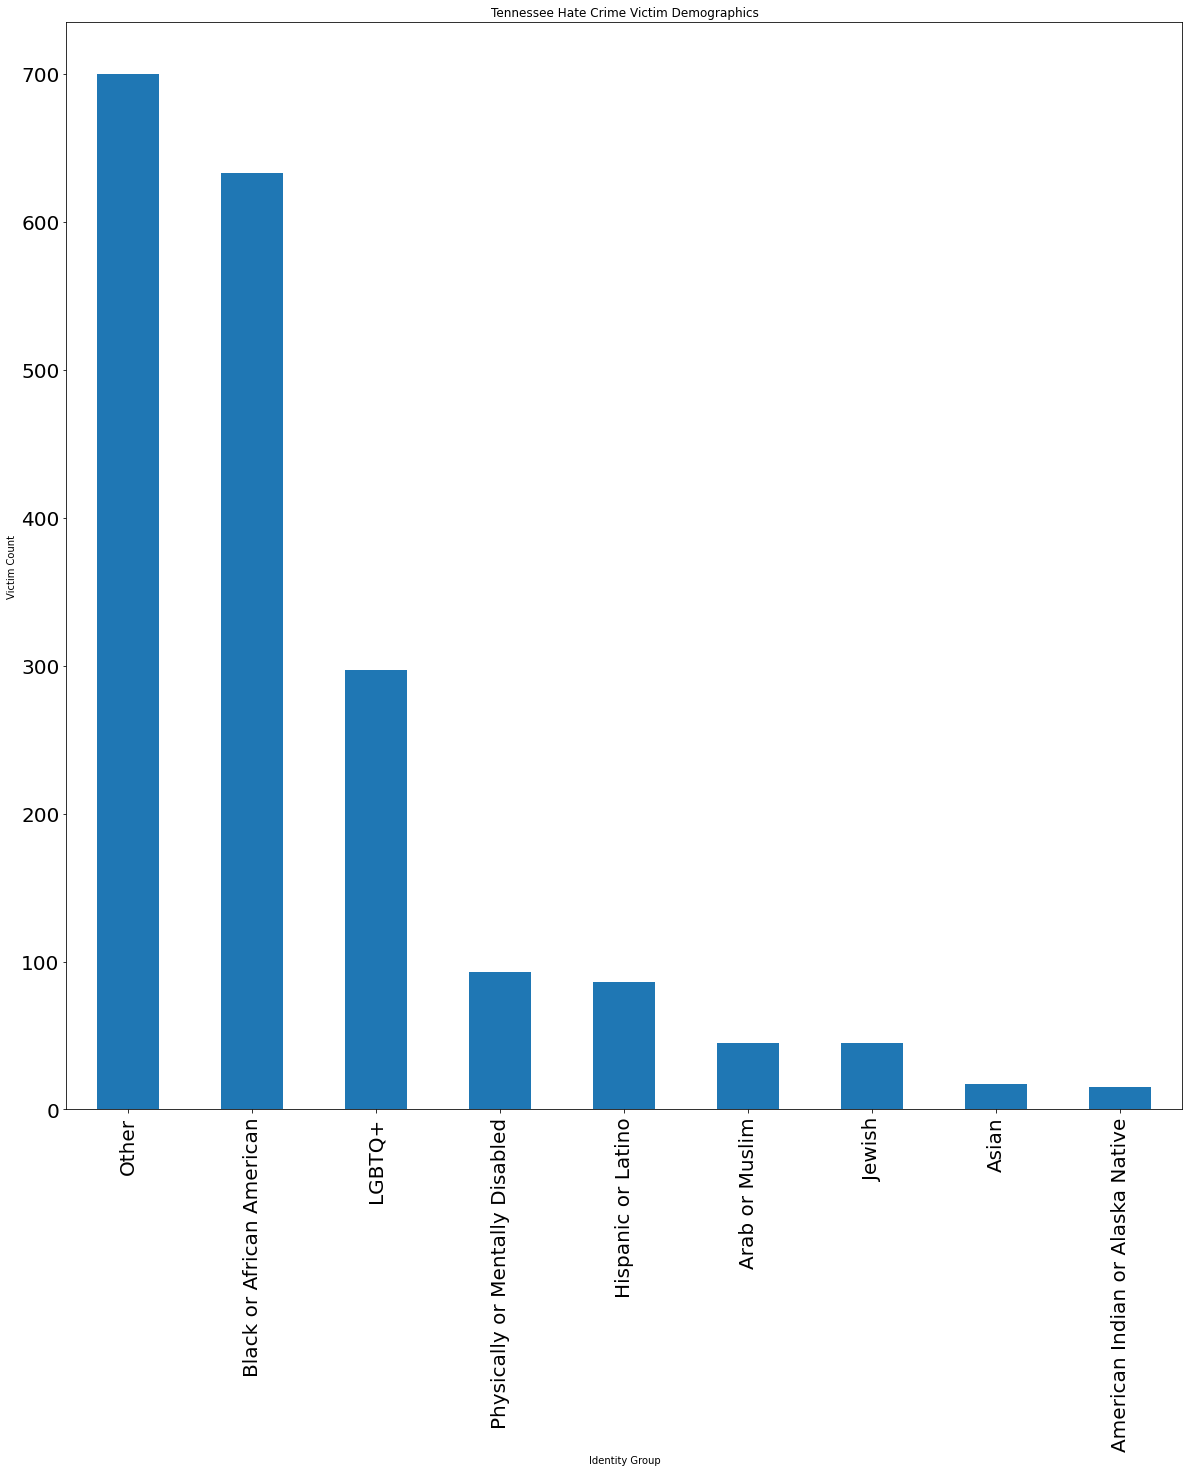

In [88]:
 #pull TN demographics
tn_vic_demo = pd.read_csv('../data/tn_vic_demo.csv')
tn_vic_demo.plot.bar(x = 'Identity Group', y = 'DEMO_COUNT', figsize = (20,20), xlabel = 'Identity Group', ylabel = 'Victim Count', legend = False, title = 'Tennessee Hate Crime Victim Demographics', fontsize = 20)

In [89]:
tn_vic_demo

,Identity Group,DEMO_COUNT
0,Other,700
1,Black or African American,633
2,LGBTQ+,297
3,Physically or Mentally Disabled,93
4,Hispanic or Latino,86
5,Arab or Muslim,45
6,Jewish,45
7,Asian,17
8,American Indian or Alaska Native,15


In [90]:
tn_vic_demo.DEMO_COUNT.sum()

1931

<AxesSubplot:title={'center':'Nashville Average Home Value'}, xlabel='Sales Month', ylabel='Average Price'>

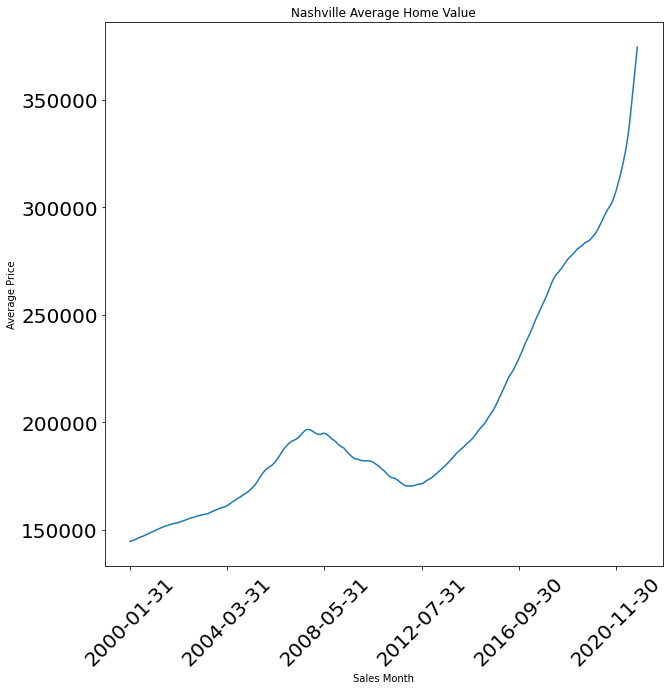

In [91]:
tn_hvi = hvi_melt[hvi_melt['RegionName'] == 'Nashville'].sort_values(by = 'SalesMonth', ascending = True).reset_index(drop = True)
tn_hvi_recent = tn_hvi[tn_hvi['SalesMonth'] >= '2020-01-01'].sort_values(by = 'SalesMonth', ascending = True).reset_index(drop = True)
tn_hvi.plot.line(y = 'AveragePrice', x = 'SalesMonth', legend = False, xlabel = 'Sales Month', ylabel = 'Average Price', figsize = (10, 10), rot = 45, title = 'Nashville Average Home Value', fontsize = 20)

In [92]:
tn_hvi.AveragePrice.min()

144802.0

In [93]:
tn_hvi.AveragePrice.max()

374406.0

<AxesSubplot:title={'center':'Tennessee Hate Crimes Rates by Year'}, xlabel='Year', ylabel='Offense Count'>

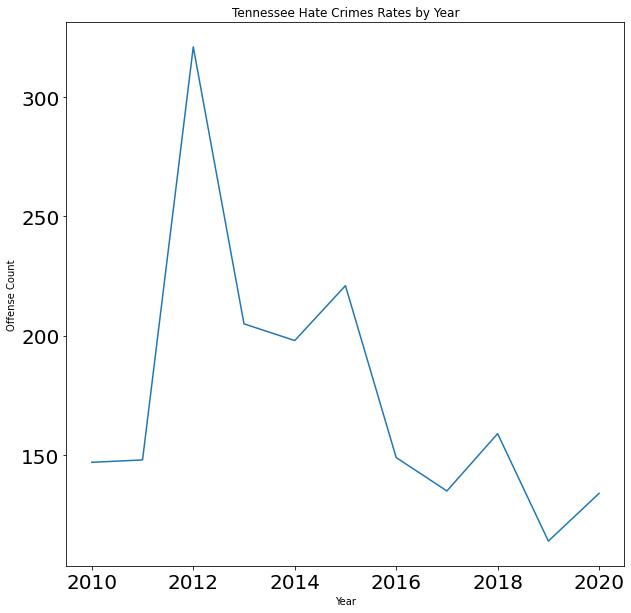

In [94]:
TN_hc_rate = hc_ready[hc_ready['STATE_ABBR'] == 'TN'].sort_values(by = 'DATA_YEAR', ascending = True)
TN_hc_rate = TN_hc_rate[['DATA_YEAR', 'OFFENSE_COUNT']]
TN_hc_rate = TN_hc_rate.groupby('DATA_YEAR').sum('OFFENSE_COUNT')
TN_hc_rate = pd.DataFrame(data = TN_hc_rate).reset_index()
TN_hc_rate.plot.line(x = 'DATA_YEAR', y = 'OFFENSE_COUNT', xlabel = 'Year', ylabel = 'Offense Count', title = 'Tennessee Hate Crimes Rates by Year', figsize = (10, 10), legend = False, fontsize = 20)

In [95]:
state_price.head(1)

,STATE_ABBR,PriceRange,PriceOrder,hc_per_capita,state_order
0,AL,"Under $50,000",1,26583.0,1.0


In [96]:
#now find average HVI and LSP in state with lowest average price
#first subset to just get since data with salesmonth since 2020
hvi_2020 = hvi_melt[hvi_melt['SalesMonth'] >= '2020-01-01'].reset_index(drop = True)
lsp_2020 = lsp_melt[lsp_melt['SalesMonth'] >= '2020-01-01'].reset_index(drop = True)
safest = state_price.head(1)
safest = safest['STATE_ABBR'].to_list()
safest_hvi = hvi_2020[hvi_2020['STATE_ABBR'].isin(safest)].head(1).reset_index(drop = True)
safest_hvi

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,Enterprise,AL,2020-12-31,138936.0,"$100,000 - $150,000"


In [97]:
#do the same for lsp

safest_lsp = lsp_2020[lsp_2020['STATE_ABBR'].isin(safest)].head(1).reset_index(drop = True)
safest_lsp

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange
0,Birmingham,AL,2021-08-31,283300.0,"$250,000 - $300,000"


In [98]:
#now lets find how safe the state with the lowest price is
cheapest = hvi_2020[hvi_2020['AveragePrice'] == hvi_2020.AveragePrice.min()]
cheapest_state = cheapest.STATE_ABBR.to_list()
cheapest_safety = state_price[state_price['STATE_ABBR'].isin(cheapest_state)].head(1).reset_index(drop = True)
cheapest_safe_cost = cheapest.merge(cheapest_safety, on = ['STATE_ABBR', 'PriceRange'])
cheapest_safe_cost

,RegionName,STATE_ABBR,SalesMonth,AveragePrice,PriceRange,PriceOrder,hc_per_capita,state_order
0,Helena,AR,2021-02-28,30071.0,"Under $50,000",1,9500.0,14.0


In [99]:
state_price.state_order.max()

51.0